In [15]:
library(dplyr)
library(Seurat)
library(ggplot2)
library(future)
library(Cairo)
library(DoubletFinder)
library(Matrix)
library(SeuratDisk)

# mark doublet

## Pre-process

In [16]:
## read in file --------------------------------------------------------
# path to 10x directory
ipath = '/public21/home/sc90258/huangying/analysis/1.Aedes_scRNA-Seq/20231103_Aedes_midgut.2sp_rerun/1.cellranger_count/map_2022_Aaedes_midgut/outs/filtered_feature_bc_matrix'
# 'project' in 'CreateSeuratObject'
project = 'Aedes_midgut'
# read in file
data10x = Read10X(
    data.dir = ipath
)
# make Seurat object of RNA data
# create Seurat object
seurat_obj =  CreateSeuratObject(
    counts = data10x, 
    assay = "RNA",
    project = project, 
    min.cells = 3
)

## filter out cells --------------------------------------------------------
min_nFeature_RNA = 100
# maximum nFeature_RNA
max_nFeature_RNA = 2500
# maximum percent.mt
max_percent.mt = 30

mt_genes_part = "AAEL018658|AAEL018659|AAEL018660|AAEL018661|AAEL018662|AAEL018663|AAEL018664|AAEL018665|AAEL018666|AAEL018667|AAEL018668|AAEL018669|AAEL018670|AAEL018671|AAEL018672|AAEL018673|AAEL018674|AAEL018675|AAEL018676|AAEL018677|AAEL018678|AAEL018679|AAEL018680|AAEL018681|AAEL018682|AAEL018683|AAEL018684|AAEL018685|AAEL018686|AAEL018687|AAEL018688|AAEL018689|AAEL018690|AAEL018691|AAEL018692|AAEL018693|AAEL018694|AAEL020667"
seurat_obj[["percent.mt"]] <- PercentageFeatureSet(
    seurat_obj,
    pattern = mt_genes_part,
    )
seurat_obj <- subset(
    seurat_obj, 
    subset = nFeature_RNA > as.numeric(min_nFeature_RNA) & nFeature_RNA < as.numeric(max_nFeature_RNA) & percent.mt < as.numeric(max_percent.mt),
)
seurat_obj_data <- GetAssayData(seurat_obj, assay = "RNA")
# remove MT genes
mt_genes = c("AAEL018658", "AAEL018659", "AAEL018660", "AAEL018661", "AAEL018662", "AAEL018663", "AAEL018664", "AAEL018665", "AAEL018666", "AAEL018667", "AAEL018668", "AAEL018669", "AAEL018670", "AAEL018671", "AAEL018672", "AAEL018673", "AAEL018674", "AAEL018675", "AAEL018676", "AAEL018677", "AAEL018678", "AAEL018679", "AAEL018680", "AAEL018681", "AAEL018682", "AAEL018683", "AAEL018684", "AAEL018685", "AAEL018686", "AAEL018687", "AAEL018688", "AAEL018689", "AAEL018690", "AAEL018691", "AAEL018692", "AAEL018693", "AAEL018694", "AAEL020667")
seurat_obj_data <- seurat_obj_data[
    -(which(rownames(seurat_obj_data) %in% c(mt_genes))),]
seurat_obj <- subset(seurat_obj, features = rownames(seurat_obj_data))

## do normalization --------------------------------------------------------
seurat_obj <- NormalizeData(seurat_obj, normalization.method = "LogNormalize", scale.factor = 10000)
# feature selection
# Identification of highly variable features
seurat_obj <- FindVariableFeatures(seurat_obj, selection.method = "vst", nfeatures = 2000)
# scaling data
all.genes <- rownames(seurat_obj)
seurat_obj <- ScaleData(seurat_obj, features = all.genes)

## PCA reduce dimension ----------------------------------------------------
seurat_obj <- RunPCA(seurat_obj, features = VariableFeatures(object = seurat_obj))
# runUMAP
seurat_obj <- RunUMAP(seurat_obj, dims = 1:50)

Centering and scaling data matrix

PC_ 1 
Positive:  AAEL003060, AAEL001863, AAEL004798, AAEL014516, AAEL006011, AAEL013703, AAEL026466, AAEL013623, AAEL022570, AAEL013885 
	   AAEL006425, AAEL009760, AAEL008769, AAEL010782, AAEL008784, AAEL013628, AAEL009844, AAEL008079, AAEL001690, AAEL015136 
	   AAEL002263, AAEL023729, AAEL013774, AAEL003317, AAEL000500, AAEL009244, AAEL003066, AAEL008428, AAEL010196, AAEL006483 
Negative:  AAEL024454, AAEL017012, AAEL025552, AAEL022285, AAEL019974, AAEL023187, AAEL028021, AAEL013723, AAEL019986, AAEL008078 
	   AAEL019599, AAEL008953, AAEL008390, AAEL003658, AAEL004592, AAEL001832, AAEL021016, AAEL008961, AAEL007963, AAEL010907 
	   AAEL028205, AAEL020061, AAEL018219, AAEL025250, AAEL012539, AAEL018700, AAEL019473, AAEL019474, AAEL019604, AAEL019824 
PC_ 2 
Positive:  AAEL002759, AAEL010975, AAEL019799, AAEL006872, AAEL026217, AAEL019525, AAEL012207, AAEL026967, AAEL010205, AAEL002417 
	   AAEL010850, AAEL001673, AAEL002572, AAEL019618, AAEL022136

In [17]:
# https://cloud.tencent.com/developer/article/1825672
nExp <- round(ncol(seurat_obj) * 0.04)  # expect 4% doublets
data.filt <- doubletFinder_v3(
    seurat_obj, 
    pN = 0.25, # https://cloud.tencent.com/developer/article/1825672
    pK = 0.09, 
    nExp = nExp, 
    PCs = 1:50)

[1] "Creating 1510 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."


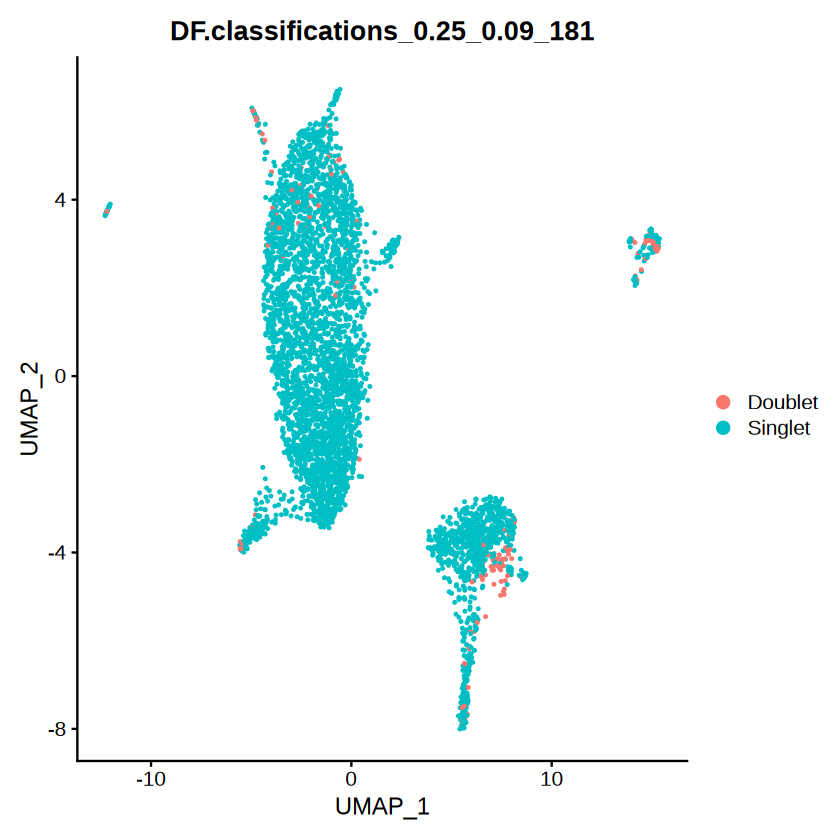

In [18]:
DF.name = colnames(data.filt@meta.data)[grepl("DF.classification", colnames(data.filt@meta.data))]

DimPlot(data.filt, group.by = DF.name)

In [19]:
# save seurat_obj
opath_seurat_obj = 'mark_doublet.seurat_obj.rds'
saveRDS(data.filt, file = opath_seurat_obj)
# write h5ad file
SaveH5Seurat(data.filt, filename = "mark_doublet.seurat_obj.h5Seurat")
Convert("mark_doublet.seurat_obj.h5Seurat", dest = "h5ad")

Creating h5Seurat file for version 3.1.5.9900

Adding counts for RNA

Adding data for RNA

Adding scale.data for RNA

Adding variable features for RNA

Adding feature-level metadata for RNA

Adding cell embeddings for pca

Adding loadings for pca

No projected loadings for pca

Adding standard deviations for pca

No JackStraw data for pca

Adding cell embeddings for umap

No loadings for umap

No projected loadings for umap

No standard deviations for umap

No JackStraw data for umap

Validating h5Seurat file

Adding scale.data from RNA as X

Transfering meta.features to var

Adding data from RNA as raw

Transfering meta.features to raw/var

Transfering meta.data to obs

Adding dimensional reduction information for pca

Adding feature loadings for pca

Adding dimensional reduction information for umap

